In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

# 将缓存功能启用，并指定缓存目录（可选）
ox.settings.use_cache = True

在 GraphExplorer 中，GTFS 数据主要用于描述公共交通的网络、时刻和换乘关系，而在你的场景中，如果用 OSM 的 highway 信息代替 GTFS 信息，那么它实际上提供了公路网络的几何、属性（如道路等级、限速等）和连接关系。

具体来说，可以这样映射两者的角色：  

- **GTFS 存储 vs. OSM Highway 数据**  
  在 GraphExplorer 中，GtfsStorage 用于存储公共交通数据，而在基于 OSM 的场景中，你需要构建一个类似的存储结构，将 OSM 的 highway 元素（道路）解析并存储起来。每条 highway 就包含了道路属性，比如道路类别、速度限制、是否双向等信息。  

- **PtGraph vs. OSM 路网图**  
  GraphExplorer 中的 PtGraph 构造了基于 GTFS 数据的公共交通网络；而在你的场景中，可以用 OSM 数据构建道路网络图（例如使用 NetworkX 或 GraphHopper 自带的图结构）。其中，每个节点表示路口，边则代表道路段。  

- **边探索与筛选逻辑**  
  GraphExplorer 里，ptEdgeStream 根据当前的 GTFS 节点输出各种类型的公交边信息；而对于 OSM 公路信息，可以采用类似的逻辑，使用街道探索器（如 streetEdgeStream）来遍历所有到达或离开某个路口的 highway 边，不同点只是判断条件与权重计算，根据道路速度、类型等计算通行费用。

- **换乘成本 vs. 道路连接成本**  
  在 GTFS 中，有换乘、等待等成本，而在公路规划中，主要需要考虑转弯（转弯半径、红绿灯）或路段衔接的额外成本。你可以采用类似的转弯权重计算（参见 GHUtility.calcWeightWithTurnWeight），只不过这里边的权重由 OSM 道路属性决定。

总结来说，把 GraphExplorer 中针对 GTFS 多模式规划的思想用于 OSM 的 highway 信息时，主要工作在于：  

1. 解析 OSM 数据，构建适用于道路网络的信息存储与图模型；  
2. 使用类似的边流（edge stream）机制遍历各个路口相连的 highway 边；  
3. 调整权重计算逻辑，将公共交通中的换乘逻辑替换为适用于公路的转弯、距离和速度限制计算。  

这样，一方面保持了 GraphExplorer 中对边的遍历和筛选的整体思路，另一方面将数据源由 GTFS 转换为 OSM 的 highway 数据，完成多模式规划中从公共交通到公路网络的信息替换。

### 数据预处理

In [ ]:
class OSMNetworkStorage:
    def __init__(self, place, network_type='drive'):
        """
        根据指定地点构建 OSM 网络数据，该模块同时存储道路边信息和完整的网络图。

        参数：
        - place: 地点名称或区域边界描述
        - network_type: 道路网络类型（默认：驾车道路 'drive'）
        """
        self.place = place
        self.network_type = network_type
        # 一次性下载 OSM 道路网络数据（NetworkX MultiDiGraph）
        self.graph = ox.graph_from_place(place, network_type=network_type)
        # 解析图中所有边，将其存储为字典形式
        self.highways = self._parse_highways()

    def _parse_highways(self):
        """
        解析 OSM 图中的每条道路边，并提取相关属性（如道路类型、速度限制、是否单向、长度等）

        返回:
            highways: 字典，键为 edge_id（格式为 "u-v-key"），值为包含道路属性的字典
        """
        highways = {}
        for u, v, key, data in self.graph.edges(keys=True, data=True):
            edge_id = f"{u}-{v}-{key}"
            highway_type = data.get('highway', None)
            maxspeed = data.get('maxspeed', None)
            # oneway 属性指示当前道路边是否单向（默认 False）
            oneway = data.get('oneway', False)
            highways[edge_id] = {
                'u': u,
                'v': v,
                'highway': highway_type,
                'maxspeed': maxspeed,
                'oneway': oneway,
                'length': data.get('length', None)
            }
        return highways

    def get_graph(self):
        """
        返回构造好的道路网络图（NetworkX MultiDiGraph）
        """
        return self.graph

    def get_all_highways(self):
        """
        返回所有解析的道路边信息字典
        """
        return self.highways

    def get_edge(self, edge_id):
        """
        根据 edge_id 获取对应的道路边属性
        """
        return self.highways.get(edge_id, None)

    def shortest_path(self, origin, destination, weight='length'):
        """
        计算最短路径

        参数：
            origin: 起始节点ID
            destination: 终点节点ID
            weight: 用于计算最短路径的边权重属性（如 length、travel_time 等）

        返回：
            最短路径节点列表
        """
        return nx.shortest_path(self.graph, source=origin, target=destination, weight=weight)

    def plot_network(self):
        """
        使用 OSMnx 绘制道路网络图
        """
        ox.plot_graph(self.graph)

    def plot_route(self, route):
        """
        绘制指定路径，并用红色显示
        参数：
            route: 节点ID列表，表示所选路径
        """
        fig, ax = ox.plot_graph_route(self.graph, route, route_color='r', route_linewidth=4, node_size=0)

d:\Anaconda\envs\xiangmu\lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 11 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


节点数量: 159077
边数量: 396454
解析了 396454 条道路边
1462245982-7972255167-0 {'u': 1462245982, 'v': 7972255167, 'highway': 'secondary', 'maxspeed': None, 'oneway': False, 'length': np.float64(17.797229093921906)}
1462245982-7972255165-0 {'u': 1462245982, 'v': 7972255165, 'highway': 'secondary', 'maxspeed': None, 'oneway': True, 'length': np.float64(241.39708927930474)}
1462245982-7972255176-0 {'u': 1462245982, 'v': 7972255176, 'highway': 'secondary', 'maxspeed': None, 'oneway': False, 'length': np.float64(34.9742966140175)}
1462246010-12730056136-0 {'u': 1462246010, 'v': 12730056136, 'highway': 'primary', 'maxspeed': None, 'oneway': False, 'length': np.float64(242.159508151432)}
1462246010-12730056142-0 {'u': 1462246010, 'v': 12730056142, 'highway': 'trunk', 'maxspeed': None, 'oneway': False, 'length': np.float64(449.8227481198702)}
计算从节点 1462245982 到节点 1462246010 的最短路径:
路径: [1462245982, 7972255176, 2539589226, 7972255220, 8200951356, 8200951376, 8200951477, 8200951688, 8200951500, 8200951478, 820

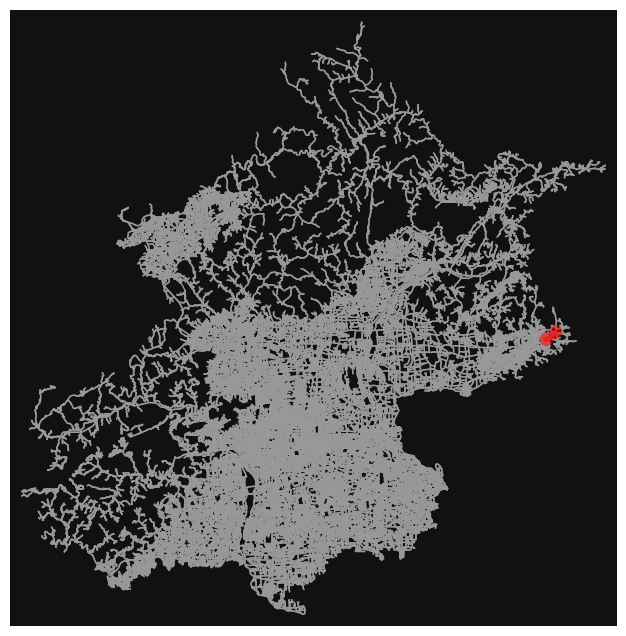

In [11]:
# 示例：构建一个地点的 OSM 网络数据
place = "北京市, 中国" 
osm_data = OSMNetworkStorage(place, network_type='drive')

# 输出节点、边及道路边解析信息
G = osm_data.get_graph()
print("节点数量:", G.number_of_nodes())
print("边数量:", G.number_of_edges())

highways = osm_data.get_all_highways()
print("解析了", len(highways), "条道路边")
for i, (eid, props) in enumerate(highways.items()):
    print(eid, props)
    if i >= 4:
        break

# 示例：计算最短路径并绘制红色路径
nodes = list(osm_data.get_graph().nodes())
if len(nodes) >= 2:
    origin, destination = nodes[0], nodes[1]
    path = osm_data.shortest_path(origin, destination, weight='length')
    print("计算从节点 {} 到节点 {} 的最短路径:".format(origin, destination))
    print("路径:", path)
    osm_data.plot_route(path)